# Remembering the past 
Suppose the state vector $\mathbf{x}_s$ is encoded in memory in a corrupted form,$\tilde{\mathbf{x}}_s$ generate from a stochastic process $\Pr(\tilde{\mathbf{x}}_s|\mathbf{x}_s)$. Then the task of memory retrieval can be formalized as computing the posterior distribution over $\mathbf{x}_s$ given $\tilde{\mathbf{x}}_s$:
$$
\begin{align}
    \Pr (\mathbf{x}_s | \tilde{\mathbf{x}}_s, \theta) &\propto \Pr(\tilde{\mathbf{x}}_s | \mathbf{x}_s, \theta) \sum_{e}\Pr(\mathbf{x}_s|e, \theta)\Pr(e)\\
    &\approx \Pr(\tilde{\mathbf{x}}_s|\mathbf{x}_{s}, \theta)\Pr(\mathbf{x}_s, \hat{e}, \theta)
\end{align}
$$

where we again have made use of the local MAP approximation. Notice that inferences about history are affected by beliefs about the event segmentation; the noise corrupting the memory trace is “corrected” by event constraints. This gives rise to Bartlett-like schematic influences on memory.

If we assume the corruption process corresponds to a spherical Gaussian perturbation of the state vector, $\tilde{\mathbf{x}}_s \sim \mathcal{N}(\mathbf{x}_s, \tau\mathbf{I})$, then the posterior distributions over scene vectors $\mathbf{x}_s$ can be expressed with as the product of two spherical Gaussian distributions:
$$
\begin{align}
   \Pr (\mathbf{x}_s | \tilde{\mathbf{x}}_s, \theta) &= \mathcal{N}\left(\mathbf{x}_s; ({\mathbf{x}}_{1:s}; \hat{e}, \theta), \beta \mathbf{I}\right ) \mathcal{N}(\mathbf{x}_s;\tilde{\mathbf{x}}_s \tau\mathbf{I})\\
   &= \mathcal{N}\left(\mathbf{x}_s; \bar{\mathbf{x}}_s, \lambda \mathbf{I}\right )
\end{align}
$$
where $f({\mathbf{x}}_{1:s}; \hat{e}, \theta)$ defines transtion dynamics of the event model and $\beta$ the noise of the process. The mean and noise of the distribution, $\bar{\mathbf{x}}_s'$ and $\lambda$ can be caluclated analytically:
$$
\begin{align}
    \bar{\mathbf{x}}_s' &= uf({\mathbf{x}}_{1:s}; \hat{e}, \theta) + (1 - u)\tilde{\mathbf{x}}_s'\\
    u&=\frac{\beta^{-1}}{\beta^{-1} + \tau^{-1}}\\
    \lambda&=\frac{1}{\beta^{-1} + \tau^{-1}}
\end{align}
$$

Thus, the posterior mean function is a precision-weighted linear combination of the memory trace and the predicted state under the event model and the noise of the distribution is a weighted average of the transition corruption noise processes. The assumption of a spherical covariance function for both source of noise is a symplifying assumption that can be loosened.

## Graphical model of the memory corruption process
<img src="images/memorymodel_graph.png" width="300" height="300" />

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from models import SEM, KerasSimpleRNN

np.random.seed(3490875035)
sns.set_context('paper', font_scale=1.5)

Using TensorFlow backend.


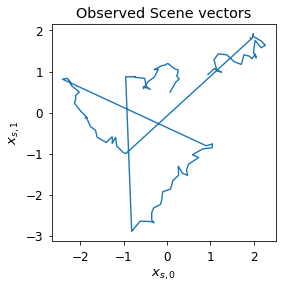

In [2]:
def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(1, N/4):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4+1, N/2):
        _x = x[n-1, :] + np.array([-0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
            
    x[N/2, :] = np.random.multivariate_normal(bs[2], Sigma)
    for n in range(N/2+1, N/4*3):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4*3, :] = np.random.multivariate_normal(bs[3], Sigma)
    for n in range(N/4*3+1, N):
        _x = x[n-1, :] + np.array([0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)      
        
    return x
betas = [0.01]
x_train = build_alternating_moving_events(100)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), 
                    np.ones(25, dtype=int)*2, np.ones(25, dtype=int)*3])

fig = plt.figure(figsize=(4, 4))
plt.plot(x_train[:, 0], x_train[:, 1])
plt.xlabel(r'$x_{s,0}$')
plt.ylabel(r'$x_{s,1}$')
plt.title('Observed Scene vectors')

Widget Javascript not detected.  It may not be installed or enabled properly.



Adjusted Mutual Information: 0.946761405681
Adjusted Rand Score: 0.947259772258

[0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


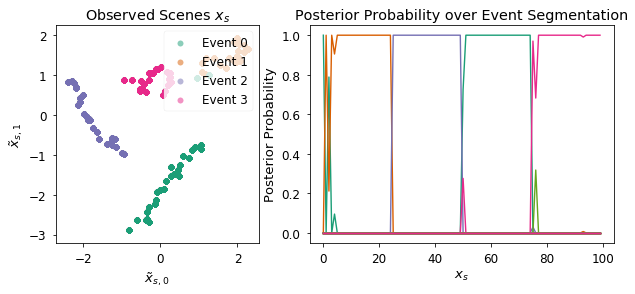

In [3]:
# SEM parameters
K = 20  # maximum number of event types
lmda = 1.0  # stickyness parameter
alfa = 1.00  # concentration parameter
beta = 1. / np.sum([1./b for b in betas])# transition noise


# define plotting function
import seaborn as sns
from sklearn import metrics

def plot_segmentation(post, y):
    cluster_id = np.argmax(post, axis=1)
    cc = sns.color_palette('Dark2', post.shape[1])
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw=dict(width_ratios=[1, 1.5]))
    handles = [None] * len(set(cluster_id))
    for clt in cluster_id:
        idx = np.nonzero(cluster_id == clt)[0]
        handles[clt] = axes[0].scatter(
            x_train[idx, 0], x_train[idx, 1], color=cc[clt], alpha=.5,
            label=('Event %d' % clt))
        
            
    axes[0].set_xlabel(r'$\tilde x_{s,0}$')
    axes[0].set_ylabel(r'$\tilde x_{s,1}$')
    axes[0].set_title(r'Observed Scenes $x_s$')
    axes[0].legend(handles=handles, loc='upper right')

    for ii in range(post.shape[1]):
        axes[1].plot(post[:, ii], color=cc[ii])
    axes[1].set_xlabel(r'$x_s$')
    axes[1].set_ylabel('Posterior Probability')
    axes[1].set_title('Posterior Probability over Event Segmentation')

    y_hat = np.argmax(post, axis=1)
    print "Adjusted Mutual Information:", metrics.adjusted_mutual_info_score(y, y_hat)
    print "Adjusted Rand Score:", metrics.adjusted_rand_score(y, y_hat)
    print 
    print np.argmax(post, axis=1)

sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasSimpleRNN, f_opts=dict(n_epochs=50, optimizer='adam'))
sem = SEM(**sem_kwargs)
post = sem.run(x_train, K=K)
plot_segmentation(post, y)

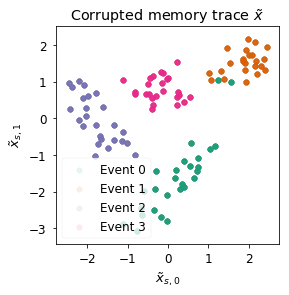

In [4]:
N, D = x_train.shape

# noise parameter
tau = 0.25
x_mem_trace = x_train + np.random.randn(N, D) * tau

def plot_trace(x_mem_trace, post):
    cluster_id = np.argmax(post, axis=1)
    cc = sns.color_palette('Dark2', post.shape[1])
    
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    handles = [None] * len(set(cluster_id))
    for clt in cluster_id:
        idx = np.nonzero(cluster_id == clt)[0]
        handles[clt] = ax.scatter(
            x_mem_trace[idx, 0], x_mem_trace[idx, 1], color=cc[clt], alpha=.1, 
            label=('Event %d' % clt))
        
    ax.set_xlabel(r'$\tilde x_{s,0}$')
    ax.set_ylabel(r'$\tilde x_{s,1}$')
    plt.legend(handles=handles)
    plt.title(r'Corrupted memory trace $\tilde x$')
    
plot_trace(x_mem_trace, post)

we also need the estimate of the events ${\hat e}_{1:n} = \left [\hat e_1, ..., \hat e_N \right ]$

In [5]:
e_hat = np.argmax(post, axis=1)
print e_hat

[0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


## Gibbs Sampling

In [6]:
from tqdm import tnrange

trials = range(1, N) # don't make a prediction for the last event!

burn_in = 100
n_samples = 500
x_samples = []

# randomly intialize the sample of x0 from the corruption process
x0 = np.random.randn(N, D) * tau + x_mem_trace

# because the beta and tau are assumed and constant, we can pre-cacluate u 
# and lambda for the weighted mean of the posterior over x
u = (1./beta) / (1./beta + 1./tau)
lmda = 1.0 / (1./beta + 1./tau)

for ii in tnrange(n_samples + burn_in):
    np.random.shuffle(trials) # randomize the order
    for t in trials:
        
        # find the last time of the last event break prior to the current time point
        diff_prev_events = np.arange(t)[e_hat[:t] != e_hat[t]]
        if len(diff_prev_events) > 0:
            t0 = np.argmax(np.arange(t)[e_hat[:t] != e_hat[t]])
        else:
            t0 = 0
        
        # pull the correct transition function
        if (t > 1) & (e_hat[t] == e_hat[t-1]):
            def f(X):
                return sem.event_models[e_hat[t]].predict_next_generative(X)
        else:
            def f(X):
                return sem.event_models[e_hat[t]].predict_f0()
        
        # construct the input vector for the model
        x_i = x0[max(t0, t-5):max(t-1, 0)]
        
        # use the likelihood function to estimate a new sample. 
        # This likelihood function is the product of two gaussians:
        #  N(x0_t; f(x0_{1:t-1}), beta_f * I) * N(x0_t; \tilde x_t , beta_mem * I )
        
        mu_t = u * f(x_i) + (1 - u) * x_mem_trace[t]
        # generate a sample from the multivariate normal
        x0[t, :] = np.random.multivariate_normal(mu_t.flatten(), lmda * np.eye(D))
        
    # 
    if ii > burn_in:
        x_samples.append(x0.copy())



Widget Javascript not detected.  It may not be installed or enabled properly.


In [7]:
x_samples_e0 = []
x_samples_e1 = []
for x0e in x_samples:
    x_samples_e0.append(x0e[e_hat == 0, :])
    
x_samples_e0 = np.concatenate(x_samples_e0)


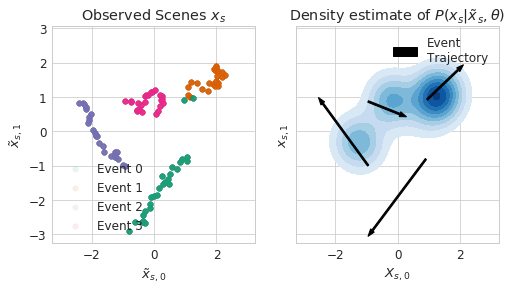

In [8]:
with sns.axes_style('whitegrid'):
    cluster_id = np.argmax(post, axis=1)
    cc = sns.color_palette('Dark2', post.shape[1])
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw=dict(width_ratios=[1, 1]),
                            sharey=True, sharex=True)
    handles = [None] * len(set(cluster_id))
    for clt in cluster_id:
        idx = np.nonzero(cluster_id == clt)[0]
        handles[clt] = axes[0].scatter(
            x_train[idx, 0], x_train[idx, 1], color=cc[clt], alpha=.1,
            label=('Event %d' % clt))
        
            
    axes[0].set_xlabel(r'$\tilde x_{s,0}$')
    axes[0].set_ylabel(r'$\tilde x_{s,1}$')
    axes[0].set_title(r'Observed Scenes $x_s$')
    axes[0].legend(handles=handles)
    
    ax = axes[1]
    x_samples0 = np.concatenate(x_samples)
    bandwidth = 0.5
    sns.kdeplot(x_samples0[:,0], x_samples0[:,1], shade=True, kernel='gus', bw=bandwidth,
                cmap="Blues", shade_lowest=False, ax=ax)

    h = ax.arrow(x_train[0, 0], x_train[0, 1], 
                 x_train[24, 0]-x_train[0, 0], x_train[24, 1]-x_train[0, 1],
                 width=0.05, fc='k', ec='k', linewidth=1.0, label='Event\nTrajectory')
    ax.arrow(x_train[25, 0], x_train[25, 1], 
             x_train[49, 0]-x_train[25, 0], x_train[49, 1]-x_train[25, 1],
              width=0.05, fc='k', ec='k', linewidth=1.0)
    ax.arrow(x_train[50, 0], x_train[50, 1], 
             x_train[74, 0]-x_train[50, 0], x_train[74, 1]-x_train[50, 1],
              width=0.05, fc='k', ec='k', linewidth=1.0)
    ax.arrow(x_train[75, 0], x_train[75, 1], 
             x_train[99, 0]-x_train[75, 0], x_train[99, 1]-x_train[75, 1],
              width=0.05, fc='k', ec='k', linewidth=1.0)
    ax.legend(handles=[h])
    
    ax.set_xlabel(r'$X_{s,0}$')
    ax.set_ylabel(r'$x_{s,1}$')
    ax.set_title(r'Density estimate of $P(x_s | \tilde x_s, \theta)$')

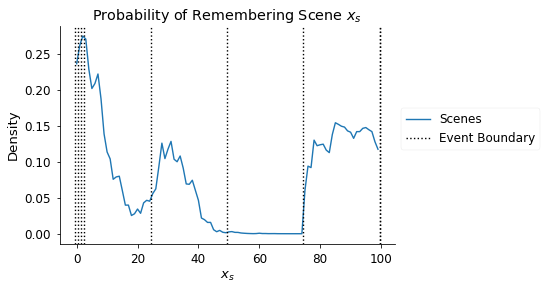

In [9]:
from sklearn.neighbors import KernelDensity


kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(x_samples0)
scores = kde.score_samples(x_train)


plt.plot(np.exp(scores), label='Scenes')

# Plot where the boundaries are
# Plot where the boundaries are
boundary_locations = [-0.5]
for ii in range(e_hat.shape[0]-1):
    if e_hat[ii] != e_hat[ii + 1]:
        boundary_locations.append(ii + 0.5)
boundary_locations.append(len(e_hat)-0.5)

y_bounds = plt.gca().get_ylim()
for b in boundary_locations:
    plt.plot([b, b], y_bounds, 'k:')
plt.plot([b, b], y_bounds, 'k:', label='Event Boundary')
plt.gca().set_ylim(y_bounds)
plt.legend(bbox_to_anchor=(1.0, 0.65))
plt.xlabel(r'$x_s$')
plt.ylabel('Density')
plt.title(r'Probability of Remembering Scene $x_s$')
sns.despine()

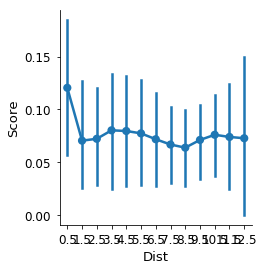

In [10]:
# get the distance to each boundary
import pandas as pd
t = range(0, len(scores))
d = [min(abs(t0 - np.array(boundary_locations))) for t0 in t]

my_df = pd.DataFrame({'Dist': d, 'Score': np.exp(scores)})
sns.factorplot(data=my_df, x='Dist',y='Score')

In [11]:
sem.event_models[1].predict_next_generative(x_train[20:25, :])

array([[ 1.75965321,  1.49704671]], dtype=float32)

In [12]:
sem.event_models[1].predict_next_generative(x_train[0, :])

array([[ 1.14280224,  1.02047372]], dtype=float32)